In [1]:
# include("other_utils.jl")
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots 
include("other_utils.jl")

┌ Info: Precompiling ExpDataSets [502e9419-551d-40e3-9007-99df92d05256]
└ @ Base loading.jl:1317
┌ Warning: Package ExpDataSets does not have PyCall in its dependencies:
│ - If you have ExpDataSets checked out for development and have
│   added PyCall as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ExpDataSets
└ Loading PyCall into ExpDataSets from project dependency, future warnings for ExpDataSets are suppressed.
  ** incremental compilation may be fatally broken for this module **



agent_ps_plot (generic function with 1 method)

In [ ]:
et =  load("Data/freeroam_dataset.jld2", "event_time_series")

In [5]:
ps =  @chain et begin 
    @subset( (:end_time .- :start_time).≥ 1.0)
    transform(:lfp => ByRow.(x->normalize(x))=>:lfp)
    @transform(@byrow lfp = values(:lfp))
    # transform(:lfp => ByRow.(x->binps(compute_power_spectrum(x),100,100))=>:pspec)
    # # transform(:pspec => ByRow.(x->smoothps(x, 5))=>:pspec)
    # @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end
save("testdata.jld2","data",ps)

# psfv =@chain ps begin 
#     @transform(@byrow power = values(:pspec))
#     # @select(:trial_type, :agent, :behavior, :region, :power)
#     @transform(@byrow freqs = :pspec.freqs)
#     @select(:rat,  :agent, :behavior, :region, :freqs, :power)
#     # DataFrames.flatten( [:freqs, :power])
#     # transform( :freqs => ByRow.(x->( x > 61.0 ? true : x < 59.0)) => :boolcol)
#     # @subset(:boolcol.==true)
#     # @transform(@byrow freqs = string(:freqs))
#     @subset(:region.=="mob", :behavior.=="Grooming")
# end
# vcat(psfv.power)


┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :lfp = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


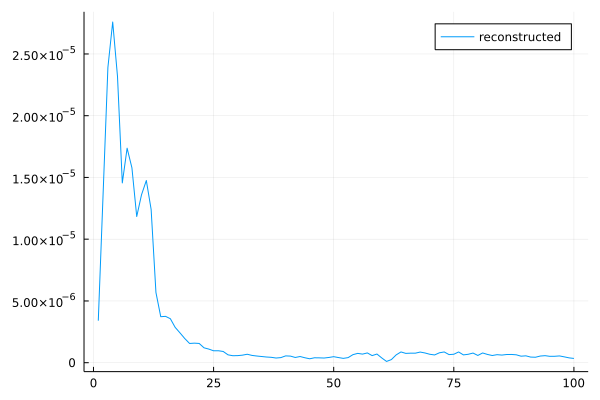

In [73]:
y=hcat(psfv.power...)'
zt=fit(ZScoreTransform, y, dims=1)
yt=StatsBase.transform(zt,y)

# y=StatsBase.reconstruct(zt, y)
# c=StatsBase.cov(yt, yt)

# c=StatsBase.normalize(c)

# yr=StatsBase.reconstruct(ZScoreTransform,y)


# # import LinearAlgebra  as LA
# # y3=(y'*y)*y[1,:]

using Measurements
ym=measurement.(yt,1)
# ym=yt
# ym2=measurement.(y, std(y,dims=1))

# # # # x1=indicatormat(psfv.behavior)'

# # # # x2=indicatormat(psfv.region)'
# # # # (x'*x)^-1*(x'*y)
i=6
c=(y'*y)
c=StatsBase.normalize(c)
yy=randn(100,1)
# yy=c*y[i,:]
yyr=StatsBase.reconstruct(zt, transpose(c*yy))
# yr=StatsBase.reconstruct(zt, transpose((ym[i,:])))
plot(yyr', label="reconstructed")
# plot!(ym2[1,:])
# plot!(yr', labels= "original")
# # plot(y[1,:])
# plot(ym[1,:])

# yr=StatsBase.reconstruct(zt, ym[1:100,:]*c)
# plot(yr[2,:])



In [45]:
m=mean(yyr,dims=1)


1×100 Matrix{Measurement{Float64}}:
 3.34104e-6±9.2e-14  1.25304e-5±8.3e-13  …  3.43588e-7±6.1e-16

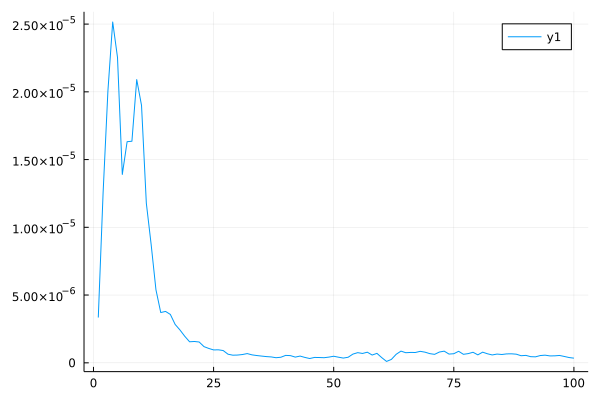

In [54]:
using Measurements
plot(Measurements.value.(m)')

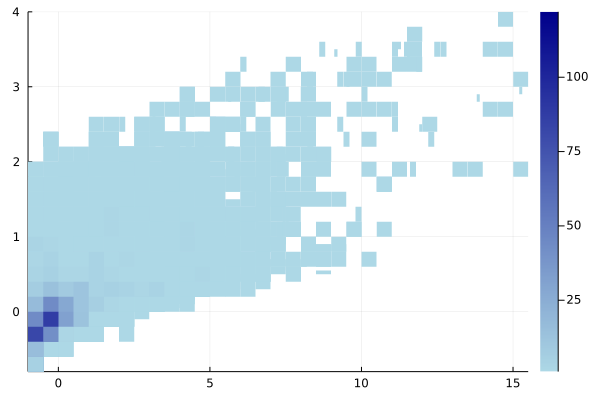

In [160]:
# using StatsPlots
# be=[10^i for i in -7:.01:-4]
# H=[StatsBase.fit(Histogram, Measurements.value.(yrr[i,:]), be) for i in 1:100]
# w=hcat(map(x->x.weights/sum(x.weights),H)...)
# heatmap(w, yticks=-6:.01:-4, xticks=1:100)
yr=randn(100,200)'*c

yrr=StatsBase.reconstruct(zt, yt)
err=std(yrr,dims=1)
m=mean(yrr,dims=1)
# scatter(yrr',markeralpha=.01, color=:blue, yaxis=:log, legend=false)
# plot(1:100, m', color=:red, legend=false, yaxis=:log)
# plot!(1:100, m'.+err', color=:black, linestyle=:dash, legend=false)
# plot!(1:100, m'.-err', color=:black, linestyle=:dash, legend=false)
histogram2d(collect(yt), collect(yt*c), c=cgrad(:blues,10))

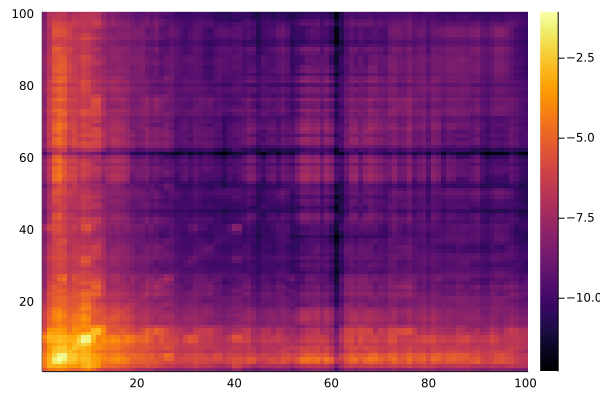

In [76]:
heatmap(log.(c))

heatmap

In [146]:
using MixedModels, StatsModels, GLM
s=@subset(psfv, :region.=="mob", :behavior.∈Ref(["null","Immobility"]), :agent .∈ Ref(["null", "Rat", "Robot", "Object"]))
fm = @formula(log10(power)~ 0 + freqs + rat&freqs + agent&freqs)
fm1 = fit(LinearModel, fm, s, contrasts = Dict(:agent => DummyCoding(;base="null")))
coefs=DataFrame(StatsBase.coeftable(fm1))
coefs_base = @chain coefs begin 
    @transform( @byrow Name = string(:Name))
    @transform(@byrow boolcol=contains.(:Name, "rat"))
    @subset(:boolcol.==false)
    @transform(@byrow boolcol=contains.(:Name, "agent"))
    @subset(:boolcol.==false)
    @transform( @byrow freq = parse(Float64, split(:Name, ":")[2]))
    @orderby(:freq)
end
coefs_base.coefs_base = coefs_base[:,"Coef."]
# base_error = Float64.(coefs_base[:,"Std. Error"])

coefs_behavior = @chain coefs begin 
    @transform( @byrow Name = string(:Name))
    @transform(@byrow boolcol=contains.(:Name, "rat"))
    @subset(:boolcol.==false)


LoadError: ArgumentError: only one level found: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0] (need at least two to compute contrasts).

In [ ]:
    @transform(@byrow boolcol=contains.(:Name, "agent"))
    @subset(:boolcol.==true)
    @transform( @byrow agent = string(split(split(:Name, ":")[2], "&")[1]))
    @transform( @byrow freq = parse(Float64, split(:Name, ":")[3]))
    select(:agent, :freq, :)
    @orderby(:freq)
end
coefs_behavior.coefs=coefs_behavior[:,"Coef."]
coefs_behavior= leftjoin(coefs_behavior, select(coefs_base, :freq, :coefs_base), on=:freq)
coefs_behavior = @transform(coefs_behavior, @byrow regpower = :coefs + :coefs_base)
coefs_behavior.err=coefs_behavior[:,"Std. Error"]
# coefs_behavior.sig=(coefs_behavior[:,"Pr(>|t|)"].<=0.01)

# using StatsPlots
# @df robot_coefs plot(freq, Coefs )
# behavior_coefs = Float64.(coefs_behavior[:,"Coef."])
# behavior_error = Float64.(coefs_behavior[:,"Std. Error"])
# using Plots
# gr()
# plot(Float64.(coefs_behavior.Name), base_coefs.+behavior_coefs, labels="Immobility: Object", linewidth=2, yaxis=:log)
# plot!(Float64.(coefs_base.Name),base_coefs, labels="Baseline", linestyle=:dash, color=:black, linewidth=2)
# # ribbon=Float64.(coefs[:,"Std. Error"]))


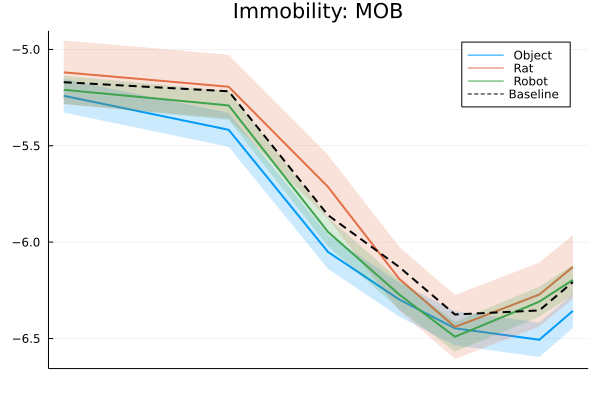

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/leobreston/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/leobreston/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [55]:
using StatsPlots
p=@df coefs_behavior plot(:freq, :regpower, ribbon=:err, fillalpha=.2, group = :agent,   linewidth=2)
# sigs=@subset(coefs_behavior, :sig.==true)
# @df sigs scatter!(p, :freq, :regpower, group = :agent, labels="", color=:grey)
@df coefs_behavior plot!(:freq, :coefs_base, labels="Baseline", linestyle=:dash, color=:black, linewidth=2, title="Immobility: MOB", xaxis=:log)


In [103]:
coefs=DataFrame(StatsBase.coeftable(fm1))
coefs = @chain coefs begin 
    @transform( @byrow Name = string(:Name))
    @transform(@byrow containsrat=contains.(:Name, "rat"))
    @subset(:containsrat.==false)
    @transform( @byrow Name = parse(Float64, split(:Name, ":")[2]))
    @orderby(:Name)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :Name = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :containsrat = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :Name = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%,containsrat
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool
1,1.0,-13.4361,0.189917,-70.7472,0.0,-13.8085,-13.0638,0
2,3.0,-11.1376,0.189917,-58.6447,0.0,-11.51,-10.7653,0
3,5.0,-11.3876,0.189917,-59.9606,0.0,-11.7599,-11.0152,0
4,7.0,-11.4259,0.189917,-60.1626,0.0,-11.7983,-11.0536,0
5,9.0,-10.6794,0.189917,-56.232,0.0,-11.0518,-10.3071,0
6,11.0,-12.0281,0.189917,-63.3333,0.0,-12.4004,-11.6557,0
7,13.0,-12.4349,0.189917,-65.4754,0.0,-12.8073,-12.0626,0
8,15.0,-12.7824,0.189917,-67.3052,0.0,-13.1548,-12.4101,0
9,17.0,-12.9016,0.189917,-67.9329,0.0,-13.274,-12.5293,0


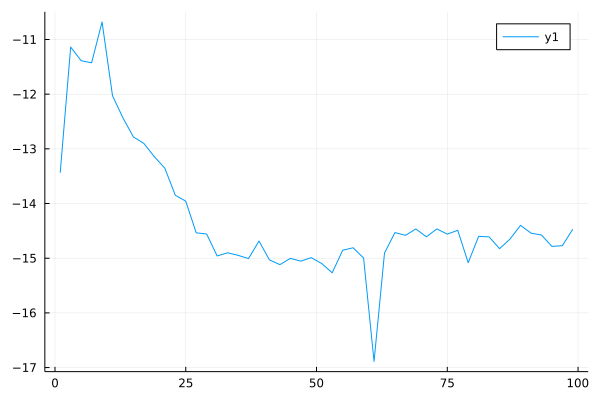

In [104]:
using Plots
gr()
plot(Float64.(coefs.Name), Float64.(coefs[:,"Coef."]))#, ribbon=Float64.(coefs[:,"Std. Error"]))


In [113]:
null_region_mps =  @chain ps begin 
    @subset(:behavior.=="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:region])
    @combine(:mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:region, :mpsvals=>:mps, :err)
end

,region,mps
,String,Array…
1,mob,"[4.69988e-6, 3.10905e-5, 2.26202e-5, 3.50006e-5, 3.94752e-5, 1.65053e-5, 7.3848e-6, 7.1621e-6, 5.03535e-6, 4.81907e-6, 3.0572e-6, 2.2845e-6, 1.54801e-6, 1.43209e-6, 1.10567e-6, 1.06462e-6, 8.12474e-7, 9.46147e-7, 7.9765e-7, 7.42934e-7, 7.62316e-7, 6.94385e-7, 7.34935e-7, 5.70061e-7, 6.08471e-7, 5.88238e-7, 9.68689e-7, 1.11359e-6, 9.84565e-7, 7.63083e-7, 1.04638e-7, 7.74113e-7, 9.12614e-7, 8.45072e-7, 1.07335e-6, 1.0077e-6, 9.06207e-7, 1.01516e-6, 9.23654e-7, 9.48507e-7, 9.80287e-7, 1.04826e-6, 8.70139e-7, 9.42007e-7, 8.87082e-7, 6.66319e-7, 1.03882e-6, 8.02686e-7, 8.05538e-7, 6.18884e-7]"
2,amyg,"[8.28946e-6, 4.28645e-5, 2.26862e-5, 1.26288e-5, 2.32465e-5, 8.50249e-6, 5.18548e-6, 4.44308e-6, 3.71038e-6, 3.93929e-6, 3.68784e-6, 2.16421e-6, 2.41067e-6, 1.60087e-6, 1.63608e-6, 1.56336e-6, 1.58627e-6, 1.25238e-6, 9.83889e-7, 9.84427e-7, 9.67186e-7, 1.11816e-6, 1.0292e-6, 7.50205e-7, 9.55206e-7, 9.91008e-7, 8.83392e-7, 7.56263e-7, 8.50103e-7, 6.95106e-7, 9.94435e-8, 5.10348e-7, 7.67446e-7, 6.72306e-7, 8.06415e-7, 6.80573e-7, 6.96764e-7, 5.38714e-7, 5.46953e-7, 6.8483e-7, 5.91565e-7, 6.06862e-7, 6.4156e-7, 5.4987e-7, 6.7696e-7, 6.49342e-7, 5.69868e-7, 5.71713e-7, 4.57288e-7, 4.57306e-7]"
3,ca2,"[5.88535e-6, 3.88901e-5, 2.10353e-5, 2.45792e-5, 5.95315e-5, 1.29309e-5, 5.46613e-6, 4.62393e-6, 3.36276e-6, 3.79454e-6, 3.11265e-6, 2.43773e-6, 1.8087e-6, 1.67596e-6, 1.39674e-6, 1.41427e-6, 1.17765e-6, 1.19289e-6, 9.20057e-7, 1.1659e-6, 8.90317e-7, 8.262e-7, 8.01781e-7, 7.43563e-7, 6.37809e-7, 6.73302e-7, 6.03828e-7, 4.90396e-7, 5.19986e-7, 3.98912e-7, 6.17614e-8, 2.82152e-7, 4.90962e-7, 3.99736e-7, 4.87094e-7, 4.05242e-7, 3.60175e-7, 3.85944e-7, 3.50431e-7, 3.58859e-7, 3.35912e-7, 3.79345e-7, 3.46206e-7, 2.9624e-7, 2.81964e-7, 3.15997e-7, 2.93135e-7, 2.58862e-7, 2.62803e-7, 2.48028e-7]"


In [114]:
behavior_agent_mps =  @chain ps begin 
    @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:behavior, :agent, :region])
    @combine(mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:behavior, :agent, :region, :mpsvals=>:mps, :err)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mps = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,behavior,agent,region,mps
,String15?,String7?,String,Array…
1,Grooming,Object,amyg,"[4.7487e-6, 4.11539e-5, 2.17428e-5, 1.4415e-5, 2.22016e-5, 4.18952e-6, 5.79955e-6, 4.33627e-6, 4.09171e-6, 2.05525e-6, 2.50419e-6, 2.86884e-6, 1.27648e-6, 1.38328e-6, 1.10554e-6, 1.68015e-6, 1.49514e-6, 7.10779e-7, 1.25931e-6, 9.01402e-7, 5.38981e-7, 1.23258e-6, 6.9347e-7, 1.4942e-6, 8.08464e-7, 1.06209e-6, 2.34424e-6, 1.09458e-6, 1.0697e-6, 1.1387e-6, 9.83674e-8, 8.111e-7, 1.3309e-6, 8.6659e-7, 1.19257e-6, 8.82073e-7, 7.01802e-7, 5.61522e-7, 9.97688e-7, 5.01234e-7, 7.77824e-7, 5.15974e-7, 4.4646e-7, 2.55256e-7, 4.62031e-7, 8.59249e-7, 5.40494e-7, 2.90796e-7, 4.17378e-7, 3.49984e-7]"
2,Grooming,Object,mob,"[3.13038e-6, 2.55273e-5, 3.37046e-5, 1.72266e-5, 4.52714e-5, 9.9705e-6, 5.63855e-6, 5.07685e-6, 3.9765e-6, 1.601e-6, 2.04377e-6, 1.1159e-6, 8.4246e-7, 6.28634e-7, 4.00649e-7, 8.89866e-7, 5.11849e-7, 4.11007e-7, 3.36721e-7, 4.76315e-7, 9.98101e-7, 8.51447e-7, 4.61949e-7, 4.79951e-7, 4.1582e-7, 5.41006e-7, 6.81619e-7, 1.89094e-6, 1.42148e-6, 1.61077e-6, 1.95659e-7, 6.49716e-7, 1.1844e-6, 1.07858e-6, 1.62948e-6, 7.60374e-7, 1.43283e-6, 6.50773e-7, 6.87817e-7, 9.91371e-7, 1.3174e-6, 5.5966e-7, 8.44296e-7, 7.13698e-7, 4.32409e-7, 3.47884e-7, 4.54665e-7, 3.44537e-7, 2.89653e-7, 2.4613e-7]"
3,Grooming,Object,ca2,"[3.04561e-6, 4.35868e-5, 2.08468e-5, 2.00662e-5, 6.35463e-5, 9.29049e-6, 3.82051e-6, 5.14953e-6, 6.55362e-6, 3.24147e-6, 2.68542e-6, 2.8768e-6, 2.32602e-6, 1.61386e-6, 7.07329e-7, 9.31695e-7, 1.16044e-6, 1.83468e-6, 1.04173e-6, 7.25671e-7, 7.42729e-7, 1.26897e-6, 5.54975e-7, 7.47976e-7, 4.02018e-7, 6.73768e-7, 5.12333e-7, 4.30927e-7, 5.31986e-7, 2.68846e-7, 6.424e-8, 2.00274e-7, 2.82226e-7, 2.94684e-7, 2.32914e-7, 2.28876e-7, 2.15845e-7, 2.0408e-7, 3.26266e-7, 1.64354e-7, 1.7977e-7, 1.86164e-7, 1.7747e-7, 1.09562e-7, 2.14046e-7, 2.17244e-7, 1.27608e-7, 1.97405e-7, 2.18758e-7, 1.57736e-7]"
4,Immobility,Robot,amyg,"[9.31572e-6, 3.44638e-5, 2.79677e-5, 1.68572e-5, 2.36745e-5, 1.098e-5, 7.36504e-6, 4.36551e-6, 3.44905e-6, 3.31695e-6, 3.14381e-6, 2.95372e-6, 1.57078e-6, 1.77148e-6, 1.62047e-6, 1.23323e-6, 1.43077e-6, 1.24268e-6, 1.06905e-6, 1.06314e-6, 7.28899e-7, 1.00431e-6, 1.04495e-6, 6.26268e-7, 6.67459e-7, 5.13059e-7, 7.4997e-7, 5.60466e-7, 6.86549e-7, 4.71534e-7, 7.48864e-8, 3.74797e-7, 5.33396e-7, 5.82685e-7, 5.01516e-7, 5.6438e-7, 5.18603e-7, 4.38408e-7, 3.48097e-7, 4.04577e-7, 4.12274e-7, 3.85369e-7, 2.93646e-7, 4.0419e-7, 3.98749e-7, 3.35878e-7, 3.01561e-7, 3.29238e-7, 2.57904e-7, 3.81481e-7]"
5,Immobility,Robot,ca2,"[7.38063e-6, 2.90404e-5, 2.42269e-5, 2.14965e-5, 5.6293e-5, 1.5989e-5, 7.7597e-6, 3.76483e-6, 3.32661e-6, 2.90292e-6, 2.75103e-6, 2.32466e-6, 1.69736e-6, 1.27975e-6, 1.28861e-6, 1.10153e-6, 1.1027e-6, 7.5368e-7, 7.66038e-7, 9.23192e-7, 7.49414e-7, 9.89404e-7, 4.91244e-7, 6.16316e-7, 6.81678e-7, 4.34971e-7, 5.55646e-7, 4.06267e-7, 4.53576e-7, 3.59109e-7, 5.6615e-8, 2.79405e-7, 3.20426e-7, 3.82838e-7, 2.66168e-7, 2.56622e-7, 3.11831e-7, 2.94753e-7, 2.05607e-7, 2.01341e-7, 2.14706e-7, 2.05942e-7, 1.47954e-7, 2.16e-7, 2.6869e-7, 2.05818e-7, 1.67147e-7, 2.06465e-7, 1.21327e-7, 1.88412e-7]"
6,Immobility,Robot,mob,"[4.22724e-6, 2.26483e-5, 1.93589e-5, 2.86438e-5, 4.01476e-5, 1.83173e-5, 9.14862e-6, 6.81456e-6, 5.12395e-6, 4.66804e-6, 2.46648e-6, 2.29494e-6, 1.42322e-6, 1.41247e-6, 1.07587e-6, 7.55534e-7, 1.01834e-6, 9.14131e-7, 8.3896e-7, 7.24273e-7, 6.75487e-7, 9.1267e-7, 7.88543e-7, 5.79749e-7, 7.48101e-7, 5.84932e-7, 5.48507e-7, 6.03482e-7, 5.74215e-7, 5.21651e-7, 7.00532e-8, 5.3847e-7, 7.07961e-7, 9.92074e-7, 9.28404e-7, 9.12474e-7, 8.65488e-7, 7.7715e-7, 8.07028e-7, 5.77113e-7, 7.32937e-7, 7.20301e-7, 6.81962e-7, 6.82412e-7, 5.62494e-7, 5.77666e-7, 6.28398e-7, 4.79535e-7, 5.17027e-7, 6.14398e-7]"
7,Approach_rat2,Rat,ca2,"[6.00078e-6, 4.17474e-5, 2.36244e-5, 1.95203e-5, 7.93429e-5, 1.3181e-5, 4.83323e-6, 4.15251e-6, 3.71382e-6, 4.40506e-6, 2.43626e-6, 3.17809e-6, 2.12498e-6, 1.9958e-6, 1.58342e-6, 1.23336e-6, 1.72166e-6, 1.0

In [ ]:
@subset(behavior_agent_mps, :agent.=="Object", :behavior.=="Immobility", :region.=="amyg").mps

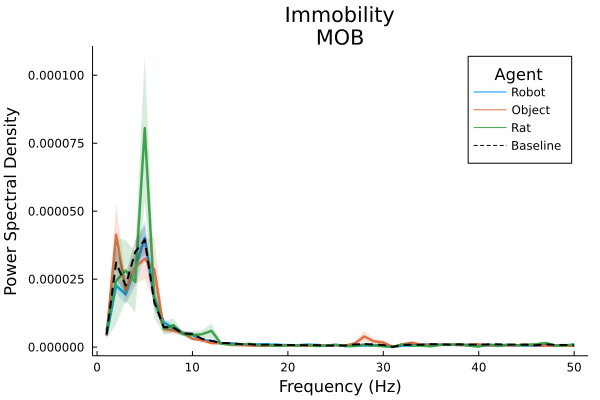

In [153]:
  b="Immobility"; r="MOB"
s=@subset(behavior_agent_mps, :behavior.== b, :region.== lowercase(r))
# s=@orderby(s, :agent)
labels =reshape(s.agent,1,length(s.agent)) 
# labels =map(x->"Agent: "*x, labels)
specs = s.mps
errs = s.err

gr()
p=plot(
    # freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    label=labels, 
    # xaxis=:log,
    # yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=b*"\n"*r,
    linewidth=2.5,
    grid=false,
    
)
ns=@subset(null_region_mps, :region.== lowercase(r))
plot!(p, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2, linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="Agent")




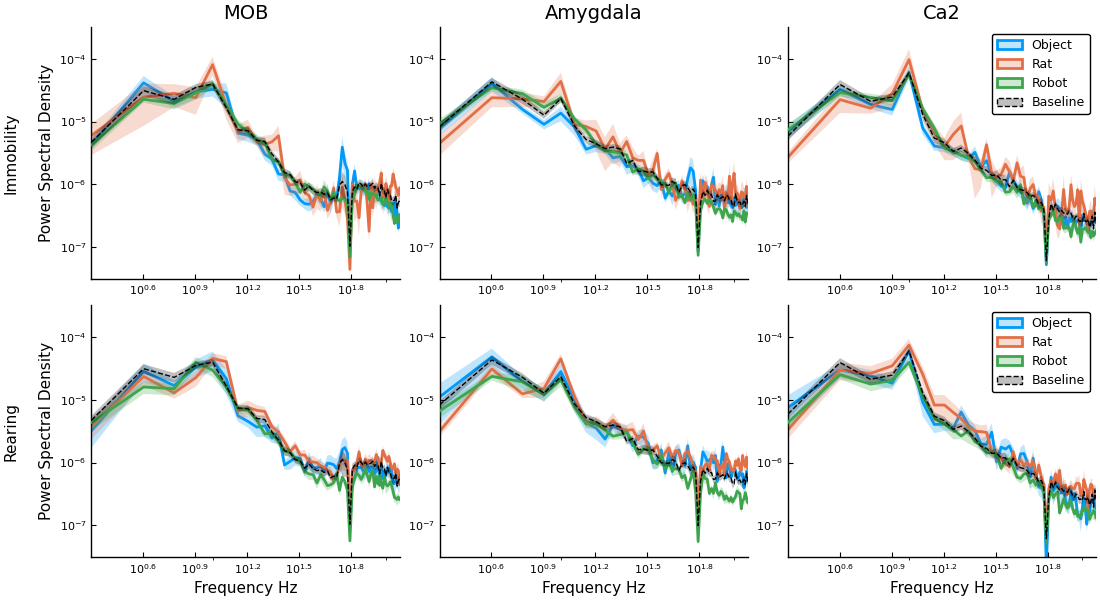

sys:1: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [293]:
import PyPlot
pyplot()
imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density")
imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
plot!(imm_amyg, title="Amygdala", xlabel="")
imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
plot!(rear_amyg, title="", xlabel="Frequency Hz")
rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
plot!(p, grid=false, size = (1100, 600))
plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")


In [313]:
rat_mps =  @chain ps begin 
    # @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:rat, :region])
    @combine(mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select( :rat, :region, :mpsvals=>:mps, :err)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mps = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,rat,region,mps
,String15?,String,Array…
1,RRSD18,amyg,"[8.02866e-6, 5.76786e-5, 2.18268e-5, 1.31345e-5, 1.94383e-5, 7.97574e-6, 5.31429e-6, 5.18156e-6, 3.93366e-6, 3.07519e-6, 3.90651e-6, 3.0989e-6, 2.3433e-6, 2.06718e-6, 1.66039e-6, 1.71776e-6, 1.35319e-6, 1.18312e-6, 1.31203e-6, 9.14185e-7, 9.5857e-7, 9.69217e-7, 1.35007e-6, 1.50856e-6, 1.04444e-6, 1.11872e-6, 2.19532e-6, 1.95598e-6, 1.55863e-6, 1.26379e-6, 1.14044e-7, 1.10946e-6, 1.55977e-6, 1.27037e-6, 1.37168e-6, 1.06316e-6, 1.35336e-6, 1.28576e-6, 1.06561e-6, 8.39476e-7, 8.15732e-7, 9.86097e-7, 1.02445e-6, 5.88951e-7, 8.70444e-7, 1.0096e-6, 9.10224e-7, 5.57751e-7, 6.16115e-7, 6.39107e-7, 6.7998e-7, 6.28488e-7, 6.02657e-7, 6.83236e-7, 5.73674e-7, 6.41024e-7, 5.28218e-7, 4.56248e-7, 5.75999e-7, 5.82967e-7]"
2,RRSD18,mob,"[3.93877e-6, 3.85467e-5, 2.7435e-5, 3.65314e-5, 3.9993e-5, 2.2927e-5, 6.76845e-6, 6.22032e-6, 5.48589e-6, 3.52033e-6, 2.61709e-6, 1.60436e-6, 1.33485e-6, 1.15252e-6, 9.30593e-7, 1.0364e-6, 7.25085e-7, 7.02652e-7, 6.18274e-7, 7.07451e-7, 8.81344e-7, 7.53428e-7, 9.6721e-7, 8.14728e-7, 7.38758e-7, 8.20181e-7, 1.59191e-6, 3.96506e-6, 2.65095e-6, 2.1565e-6, 1.74791e-7, 1.14641e-6, 1.32291e-6, 1.11325e-6, 1.19226e-6, 1.0994e-6, 1.05927e-6, 9.67394e-7, 1.04026e-6, 9.09113e-7, 8.62609e-7, 7.38596e-7, 8.25436e-7, 8.61022e-7, 8.45923e-7, 4.75766e-7, 6.20379e-7, 5.64083e-7, 4.86337e-7, 4.87006e-7, 4.73194e-7, 5.47599e-7, 4.21656e-7, 5.05822e-7, 4.53616e-7, 3.184e-7, 4.72986e-7, 3.19445e-7, 3.14152e-7, 2.50795e-7]"
3,RRSD18,ca2,"[6.00655e-6, 4.39976e-5, 2.18576e-5, 2.13371e-5, 7.58722e-5, 1.04532e-5, 5.44892e-6, 5.55706e-6, 5.41704e-6, 4.35793e-6, 3.45716e-6, 3.36252e-6, 2.13246e-6, 2.23204e-6, 1.84223e-6, 1.56865e-6, 1.25934e-6, 1.41146e-6, 1.41392e-6, 1.01614e-6, 9.9012e-7, 1.14738e-6, 8.92682e-7, 8.56041e-7, 5.86466e-7, 8.21578e-7, 5.78853e-7, 6.78367e-7, 5.83142e-7, 3.56076e-7, 5.02881e-8, 3.04526e-7, 4.40842e-7, 4.17303e-7, 4.32658e-7, 5.57169e-7, 4.80327e-7, 3.80748e-7, 3.34064e-7, 2.66264e-7, 2.12872e-7, 2.45644e-7, 2.29258e-7, 2.42502e-7, 2.29277e-7, 2.84648e-7, 2.7138e-7, 2.21684e-7, 1.79321e-7, 2.10493e-7, 2.13903e-7, 2.40327e-7, 2.01061e-7, 1.8167e-7, 2.66279e-7, 2.66822e-7, 2.33102e-7, 2.19658e-7, 1.99357e-7, 2.3889e-7]"
4,RRSD28,amyg,"[5.8651e-6, 2.81179e-5, 2.73436e-5, 1.43149e-5, 2.42178e-5, 8.63917e-6, 5.92509e-6, 4.24117e-6, 3.31867e-6, 3.07304e-6, 3.10377e-6, 2.74984e-6, 1.79529e-6, 1.56425e-6, 1.53043e-6, 1.25982e-6, 1.31933e-6, 1.1079e-6, 1.12744e-6, 9.02307e-7, 7.57015e-7, 8.23477e-7, 8.93004e-7, 7.36965e-7, 6.01376e-7, 5.94514e-7, 6.01012e-7, 4.995e-7, 6.38942e-7, 3.71945e-7, 5.94502e-8, 3.81571e-7, 6.69553e-7, 5.471e-7, 4.97177e-7, 5.28305e-7, 4.19424e-7, 3.38288e-7, 3.42024e-7, 3.47724e-7, 3.07665e-7, 3.39907e-7, 2.9962e-7, 2.73026e-7, 3.1581e-7, 2.63363e-7, 2.47224e-7, 2.66078e-7, 2.5361e-7, 2.81365e-7, 2.95731e-7, 2.84738e-7, 3.20988e-7, 2.49414e-7, 2.09639e-7, 2.15293e-7, 3.03607e-7, 2.07197e-7, 2.34405e-7, 2.80538e-7]"
5,RRSD28,ca2,"[4.51677e-6, 2.43384e-5, 2.30896e-5, 1.89397e-5, 5.26348e-5, 1.29783e-5, 5.80152e-6, 3.89577e-6, 2.84202e-6, 2.48056e-6, 2.68586e-6, 2.09055e-6, 1.45048e-6, 1.18103e-6, 9.39189e-7, 8.92037e-7, 8.38845e-7, 6.88402e-7, 7.16258e-7, 6.52366e-7, 4.98131e-7, 5.64244e-7, 4.85449e-7, 4.85194e-7, 4.35727e-7, 3.87022e-7, 4.26472e-7, 2.94029e-7, 3.14545e-7, 2.6034e-7, 4.01069e-8, 2.34548e-7, 2.31174e-7, 2.36551e-7, 2.37776e-7, 1.84596e-7, 2.01587e-7, 1.60801e-7, 1.5579e-7, 1.2909e-7, 1.41305e-7, 1.40903e-7, 1.19462e-7, 1.16038e-7, 1.39181e-7, 1.33989e-7, 1.07892e-7, 1.06818e-7, 1.06355e-7, 1.12316e-7, 1.28602e-7, 1.16885e-7, 1.339e-7, 1.09944e-7, 9.02889e-8, 9.37881e-8, 1.29259e-7, 9.28303e-8, 9.31112e-8, 1.18275e-7]"
6,RRSD28,mob,"[3.84746e-6, 2.27796e-5, 1.81551e-5, 2.92961e-5, 2.42223e-5, 1.56035e-5, 7.91811e-6, 6.34965e-6, 4.54313e-6, 3.51146e-6, 2.2548e-6, 2.09613e-6, 1.28032e-6, 1.50052e-6, 1.03337e-6, 8.48297e-7, 9.35221e-7, 8.5169e-7, 8.08607e-7, 7.20762e-7, 7.17105e-7, 7.71553e-7, 6.895e-7, 5.64709e-7, 6.56712e-7

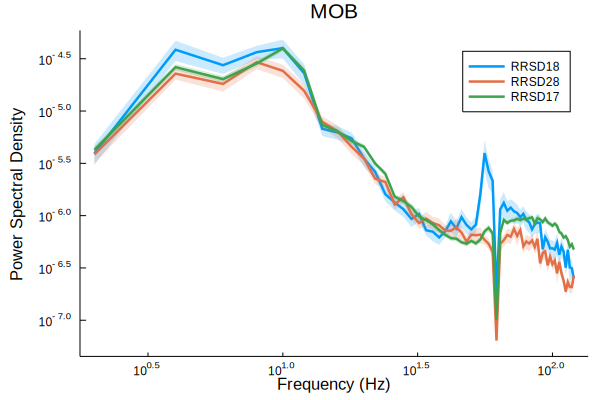

In [317]:
freqs=2:2:120;   r="MOB"
s=@subset(rat_mps, :region.== lowercase(r))
# s=@orderby(s, :agent)
labels =reshape(s.rat,1,length(s.rat)) 
# labels =map(x->"Agent: "*x, labels)
specs = s.mps
errs = s.err

gr()
p=plot(
    freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    label=labels, 
    xaxis=:log,
    yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=r,
    linewidth=2.5,
    grid=false,
    
)
# ns=@subset(null_region_mps, :region.== lowercase(r))
# plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(2,120), linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="rat")




In [318]:
using MixedModels

┌ Info: Precompiling MixedModels [ff71e718-51f3-5ec2-a782-8ffcbfa3c316]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken 

LoadError: Failed to precompile MixedModels [ff71e718-51f3-5ec2-a782-8ffcbfa3c316] to /Users/leobreston/.julia/compiled/v1.6/MixedModels/jl_UsJDXX.